<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/FaceNet_Like_Less_BiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://blog.tensorflow.org/2020/05/bigtransfer-bit-state-of-art-transfer-learning-computer-vision.html. 

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 323.8MB 48kB/s 
     |████████████████████████████████| 6.7MB 45.2MB/s 
     |████████████████████████████████| 460kB 57.2MB/s 


In [2]:
!pip install -q tensorflow-addons

In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200803


In [4]:
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import tensorflow_addons as tfa
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [5]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

In [6]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:5%]", "train[5%:10%]"],
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.0. Subsequent calls will reuse this data.


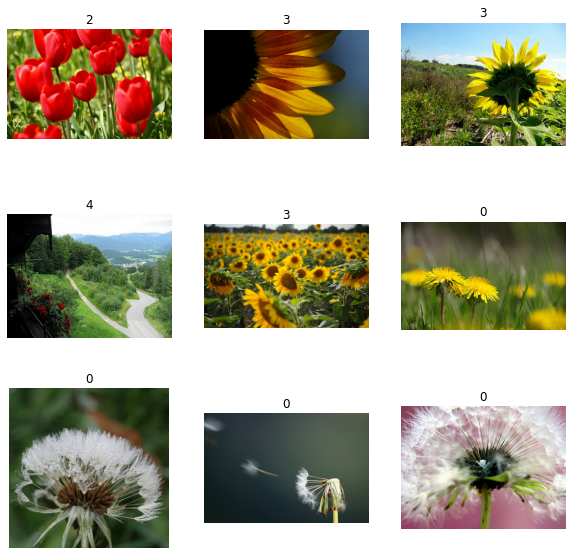

In [7]:
# Visualization
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")

In [8]:
#@title Set dataset-dependent hyperparameters

#@markdown Here we set dataset-dependent hyperparameters. For example, our dataset of flowers has 3670 images of varying size (a few hundred x a few hundred pixels), so the image size is larger than 96x96 and the dataset size is <20k examples. However, for speed reasons (since this is a tutorial and we are training on a single GPU), we will select the `<96x96 px` option and train on lower resolution images. As we will see, we can still attain strong results.

#@markdown **Algorithm details: how are the hyperparameters dataset-dependent?** 

#@markdown It's quite intuitive - we resize images to a smaller fixed size if they are smaller than 96 x 96px and to a larger fixed size otherwise. The number of steps we fine-tune for is larger for larger datasets. 

IMAGE_SIZE = "=\u003C96x96 px" #@param ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "\u003C20k examples" #@param ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
  RESIZE_TO = 160
  CROP_TO = 128
else:
  RESIZE_TO = 512
  CROP_TO = 480

if DATASET_SIZE == "<20k examples":
  SCHEDULE_LENGTH = 500
  SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
  SCHEDULE_LENGTH = 10000
  SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
  SCHEDULE_LENGTH = 20000
  SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

In [9]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 64
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = 10

DATASET_NUM_TRAIN_EXAMPLES = len([image for image in train_ds])
  
def preprocess_train(image, label):
  # Apply random crops and horizontal flips for all tasks 
  # except those for which cropping or flipping destroys the label semantics
  # (e.g. predict orientation of an object)
  image = tf.image.random_flip_left_right(image)
  image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
  image = tf.image.random_crop(image, [CROP_TO, CROP_TO, 3])
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

def preprocess_test(image, label):
  image = tf.image.resize(image, [RESIZE_TO, RESIZE_TO])
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

pipeline_train = (train_ds
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))

pipeline_test = (validation_ds.map(preprocess_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                  .batch(BATCH_SIZE)
                  .prefetch(tf.data.experimental.AUTOTUNE))

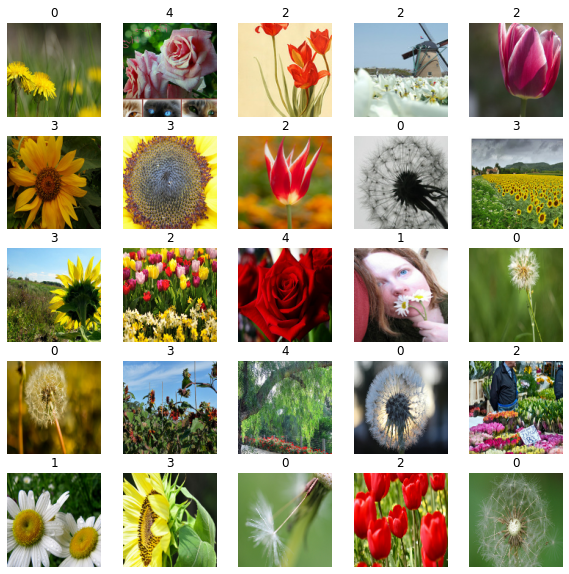

In [10]:
image_batch, label_batch = next(iter(pipeline_train))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n+1)
    plt.imshow(image_batch[n])
    plt.title(label_batch[n].numpy())
    plt.axis('off')

In [27]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r50x1/1"
module = hub.KerasLayer(model_url, trainable=True)

In [28]:
class MyBiTModel(tf.keras.Model):
  def __init__(self, module):
    super().__init__()
    self.dense1 = tf.keras.layers.Dense(128)
    self.normalize = Lambda(lambda a: tf.math.l2_normalize(a, axis=1))
    self.bit_model = module
  
  def call(self, images):
    bit_embedding = self.bit_model(images)
    dense1_representations = self.dense1(bit_embedding)
    return self.normalize(dense1_representations)

In [29]:
# Define optimiser and loss

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tfa.losses.TripletSemiHardLoss()

In [30]:
es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=2, verbose=2, mode="auto",
    restore_best_weights=True
)

In [31]:
def plot_training(H, embedding_dim):
    with plt.xkcd():
        plt.plot(H.history["loss"], label="train_loss")
        plt.plot(H.history["val_loss"], label="val_loss")
        plt.title("Embedding dim: {}".format(embedding_dim))
        plt.legend(loc="lower left")
        plt.show()

Epoch 1/400
10/10 [==============================] - ETA: 0s - loss: 0.8836WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_test_batch_end` time: 0.1724s). Check your callbacks.


10/10 [==============================] - 20s 2s/step - loss: 0.8828 - val_loss: 0.8605
Epoch 2/400
10/10 [==============================] - 5s 488ms/step - loss: 0.7738 - val_loss: 0.7497
Epoch 3/400
10/10 [==============================] - 5s 493ms/step - loss: 0.5859 - val_loss: 0.5963
Epoch 4/400
10/10 [==============================] - 5s 493ms/step - loss: 0.3733 - val_loss: 0.4742
Epoch 5/400
10/10 [==============================] - 5s 491ms/step - loss: 0.2401 - val_loss: 0.3926
Epoch 6/400
10/10 [==============================] - 5s 504ms/step - loss: 0.1409 - val_loss: 0.3534
Epoch 7/400
10/10 [==============================] - 5s 485ms/step - loss: 0.0734 - val_loss: 0.3226
Epoch 8/400
10/10 [==============================] - 5s 502ms/step - loss: 0.0561 - val_loss: 0.3037
Epoch 9/400
10/10 [==============================] - 5s 498ms/step - loss: 0.0374 - val_loss: 0.2942
Epoch 10/400
10/10 [==============================] - 5s 494ms/step - loss: 0.0193 - val_loss: 0.2924
Epo

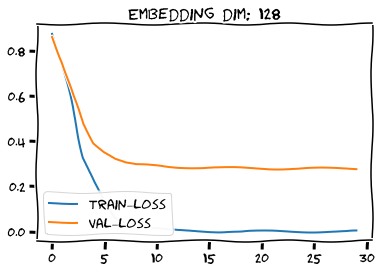

In [32]:
model = MyBiTModel(module=module)
model.compile(optimizer=optimizer,
              loss=loss_fn)

start = time.time()
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= int(SCHEDULE_LENGTH / STEPS_PER_EPOCH),  
    validation_data=pipeline_test,
    callbacks=[es]  
                                   
)
end = time.time()-start
print("Model takes {} seconds to train".format(end))

plot_training(history, 128)

In [34]:
model.save_weights("facenet_like_less_data_bit.h5")

In [35]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [36]:
!gsutil cp -r facenet_like_less_data_bit.h5 gs://image-retrieval-system/

Copying file://facenet_like_less_data_bit.h5 [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/90.9 MiB.                                     
